In [230]:
!pip3 install saxpy

In [319]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from pmdarima.arima import auto_arima
import multiprocessing as mp
import saxpy
import nltk
from nltk import bigrams
from nltk import trigrams
from saxpy.sax import sax_via_window
from saxpy.sax import sax_via_window
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string

sns.set(rc={'figure.figsize':(11.7,8.27)})

## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

df2.loc[df2['ATT_FLAG'] == -999, 'ATT_FLAG'] = 0

In [320]:
def discretize(original_signal, paa_size=3, window_size=3, amount_of_levels=3):
    sax1 = sax_via_window(dat, window_size, paa_size, amount_of_levels)
    indices = []
    for k, v in sax1.items():
        indices.extend(v)
    indices.sort()
    discrete_signal = pd.DataFrame(index=indices, columns=["word"])
    for k, v in sax1.items():
        discrete_signal.loc[v] = k
    return discrete_signal

In [321]:
def get_trigram(discrete_signal):
    ts_string = " ".join(discrete_signal['word'])
    tokens = nltk.word_tokenize(ts_string)
    tri_tokens = trigrams(tokens)
    tri_list = [tuple(trigram) for trigram in tri_tokens]
    fdist = nltk.FreqDist(tri_list)
    trigram_df = pd.DataFrame.from_dict(fdist,orient='index')
    trigram_df_prob = trigram_df/trigram_df.sum()
    return pd.Series(tri_list, index=discrete_signal.index[:-2]), trigram_df_prob[0]

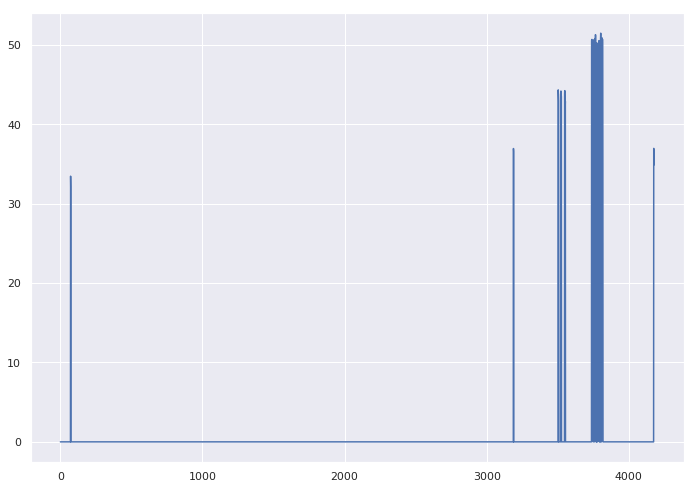

In [322]:
sns.lineplot(data=df2['F_PU6'])

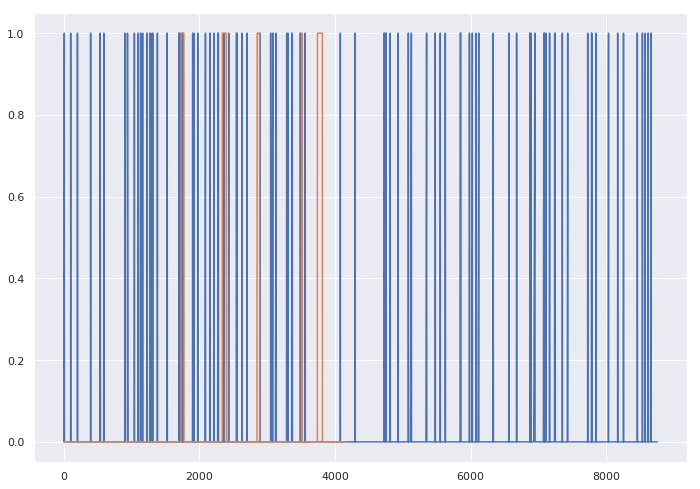

In [310]:
## Select a target, discretize and see if it overlaps

target = 'L_T1'
dat1 = df1[target].values
tris, triprob = get_trigram(discretize(dat1))

dat2 = df2[target].values
tris2, tris2prob = get_trigram(discretize(dat2))

threshold = min(triprob)
fig, ax = plt.subplots()
sns.lineplot(data=tris2.apply(lambda x: triprob.get(x, -1))<=threshold, ax=ax)
sns.lineplot(data=df2['ATT_FLAG'], ax=ax)

In [311]:
## Count the occurences of different words
word_counts = discrete_signal['word'].value_counts()

   word
0  aabc
1  aacc
3  abcc
5  accb
6  acbb


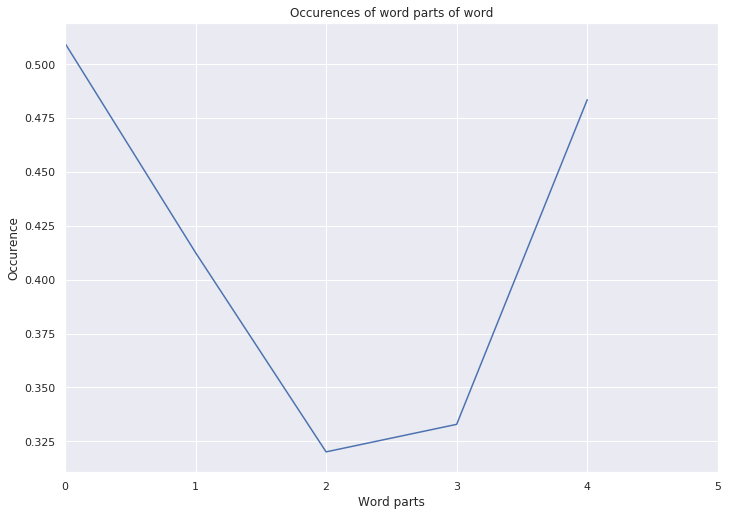

In [312]:
## Show example:
lent = 5
print(discrete_signal[0:lent])
plot = sns.lineplot(data=dat[0:lent])
plot.set(xlim = (0,lent));
plot.set_title("Occurences of word parts of {}".format("".join(discrete_signal[0:lent])));
plot.set_ylabel("Occurence");
plot.set_xlabel("Word parts");

In [89]:
## Create a string out of it:
ts_string = " ".join(discrete_signal['word'])

In [92]:
## Creating tokens and do n-gram stuff

tokens = nltk.word_tokenize(ts_string)
bi_tokens = bigrams(tokens)
tri_tokens = trigrams(tokens)
fdist = nltk.FreqDist(tri_tokens)
trigram_df = pd.DataFrame.from_dict(fdist,orient='index')

In [109]:
trigram_df_prob.loc[[('aabc', 'aacc', 'abcc')], 0]

(aabc, aacc, abcc)    0.066378
Name: 0, dtype: float64

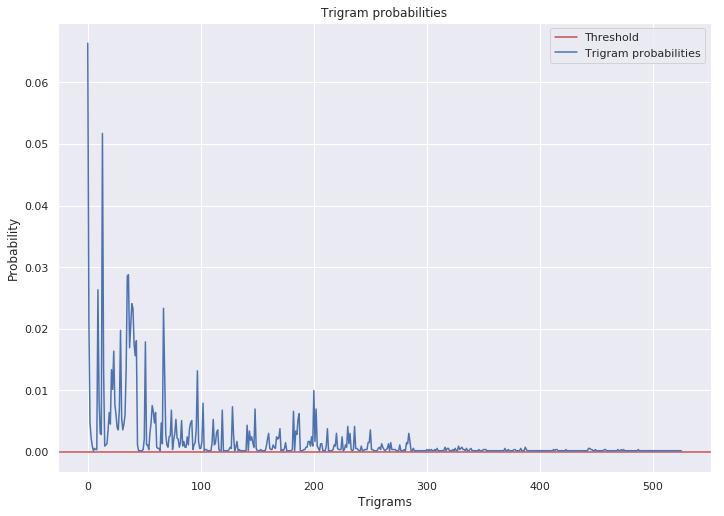

In [95]:
trigram_df_prob = trigram_df/trigram_df.sum()

fig = plt.figure()
ax = fig.add_subplot(111)
#arbitrary threshold value
threshold= min(trigram_df_prob)
ax.axhline(y=threshold, label='Threshold',color="r")
ax.plot(trigram_df_prob.reset_index(drop=True), label = "Trigram probabilities")
ax.set_title('Trigram probabilities')
ax.set_xlabel('Trigrams')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

In [96]:
data = df1.drop("DATETIME",1)
x = []
x = pd.DataFrame(x)
for index in range(0,len(data.columns)):
    indexname = "{}".format(data.columns[index])
    dat = data[indexname].values
    amount_of_levels = 3
    window_size = 2

    discrete_signal = []
    for t in range(len(dat)-window_size):
        dat_znorm = znorm(dat[t:t+window_size])
        discrete_signal.append(ts_to_string(dat_znorm, cuts_for_asize(amount_of_levels)))

    x[indexname] = discrete_signal
ngrams = x    



KeyboardInterrupt: 

In [ ]:
test = list(ngrams["L_T1"].iloc[:3])
test = "".join(test)
trigram_df_prob_lt1 = trigram_df_prob.sort_values(0,ascending=False)


In [ ]:
indices = []
for index in range(0,len(trigram_df_prob)):   
    indices.append("".join(trigram_df_prob.index[index]))

In [ ]:
indices = pd.Series(indices)
trigram_df_prob = trigram_df_prob.set_index(indices)
trigram_df_prob.loc[test]

In [ ]:
ngrams.head()